<a href="https://colab.research.google.com/github/lmarieta/FaceRecognition/blob/main/Face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before starting, upload data.RData file and test data. After training your model, you can download it. After saving the output file, you can also download it.

Import Libraries


In [4]:
import numpy as np
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
#from sklearn import train_test_split
import matplotlib.pyplot as plt
!pip install pyreadr
import pyreadr

Test example

In [5]:
"""
# Input data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# Output data
y = np.array([[0], [1], [1], [0]])

# Neural network
model = keras.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X, y, epochs=1000, batch_size=4)

# Test data
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

# Predictions
predictions = model.predict(X_test)

# Plot the results
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions.flatten(), cmap='viridis')
plt.title('Predictions')
plt.xlabel('Xtest1')
plt.ylabel('Xtest2')
plt.colorbar()
plt.show()

plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='viridis')
plt.title('y')
plt.xlabel('X1')
plt.ylabel('X2')
plt.colorbar()
plt.show()
"""

"\n# Input data\nX = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])\n\n# Output data\ny = np.array([[0], [1], [1], [0]])\n\n# Neural network\nmodel = keras.Sequential()\nmodel.add(layers.Dense(4, activation='relu', input_shape=(2,)))\nmodel.add(layers.Dense(1, activation='sigmoid'))\n\n# Compile model\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Train model\nmodel.fit(X, y, epochs=1000, batch_size=4)\n\n# Test data\nX_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])\n\n# Predictions\npredictions = model.predict(X_test)\n\n# Plot the results\nplt.scatter(X_test[:, 0], X_test[:, 1], c=predictions.flatten(), cmap='viridis')\nplt.title('Predictions')\nplt.xlabel('Xtest1')\nplt.ylabel('Xtest2')\nplt.colorbar()\nplt.show()\n\nplt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='viridis')\nplt.title('y')\nplt.xlabel('X1')\nplt.ylabel('X2')\nplt.colorbar()\nplt.show()\n"

Load data

In [6]:
filename = '/content/data.RData'
df = pyreadr.read_r(filename)
# Some checks
print(df['d.train'].columns)
print(df['d.test'].columns)
print(df['d.train'].count())
print(df['d.test'].count())
print(df['im.train'].head())
print(df['im.test'].head())
print(df['d.train'].shape)
print(df['d.test'].shape)
print(df['im.train'].shape)
print(df['im.test'].shape)
x_train = df['im.train']
y_train = df['d.train']
x_test = df['im.test']
y_test = df['d.test']
# Get the indices of rows containing NaN values. Note that train and test splits are random with a given seed.
nan_indices_train = x_train.index[x_train.isnull().any(axis=1)].tolist() + y_train.index[y_train.isnull().any(axis=1)].tolist()
nan_indices_test = x_test.index[x_test.isnull().any(axis=1)].tolist() + y_test.index[y_test.isnull().any(axis=1)].tolist()

# Drop rows containing NaN values
x_train = x_train.drop(x_train.index[nan_indices_train])
y_train = y_train.drop(y_train.index[nan_indices_train])
x_test = x_test.drop(x_test.index[nan_indices_test])
y_test = y_test.drop(y_test.index[nan_indices_test])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')
Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inn

Single layer model

In [7]:
# Define the model (two hidden layers)
pixel_num = x_train.shape[1]
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(pixel_num,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(y_train.shape[1])  # Output layer with 2 units per keypoint (x and y coordinates)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(x_train, y_train, epochs=400, batch_size=32)

# Make predictions
predictions = model.predict(x_test)

# Size of the image is given, prediction cannot be outside of range
min_value = 0
max_value = 96
constrained_predictions = np.clip(predictions, min_value, max_value)

Epoch 1/400
55/55 [==============================] - 7s 5ms/step - loss: 7489.3198
Epoch 2/400
55/55 [==============================] - 0s 6ms/step - loss: 2614.6890
Epoch 3/400
55/55 [==============================] - 0s 6ms/step - loss: 2610.6694
Epoch 4/400
55/55 [==============================] - 0s 7ms/step - loss: 2606.3904
Epoch 5/400
55/55 [==============================] - 0s 7ms/step - loss: 2601.9517
Epoch 6/400
55/55 [==============================] - 0s 6ms/step - loss: 2597.4014
Epoch 7/400
55/55 [==============================] - 0s 6ms/step - loss: 2592.7710
Epoch 8/400
55/55 [==============================] - 0s 6ms/step - loss: 2588.0791
Epoch 9/400
55/55 [==============================] - 0s 6ms/step - loss: 2583.3389
Epoch 10/400
55/55 [==============================] - 0s 6ms/step - loss: 2578.5601
Epoch 11/400
55/55 [==============================] - 1s 11ms/step - loss: 2573.7502
Epoch 12/400
55/55 [==============================] - 0s 8ms/step - loss: 2568.9150


In [8]:
# First, calculate the column means along axis 0 (columns)
col_means = np.nanmean(y_train, axis=0)

# Next, create the matrix 'p' using the calculated column means
num_rows_d_test = y_test.shape[0]
num_cols_d_train = y_train.shape[1]

# Create the matrix 'p' with the specified dimensions and fill it with column means
p = np.tile(col_means, (num_rows_d_test, 1)).astype(y_train.dtypes)

# Compute RMSE
rmse = np.sqrt(np.nanmean((y_test - p) ** 2))

# Print RMSE
print('RMSE : ')
print(rmse)

RMSE : 
3.1191622311668468


In [9]:
df_predictions = pd.DataFrame(predictions)

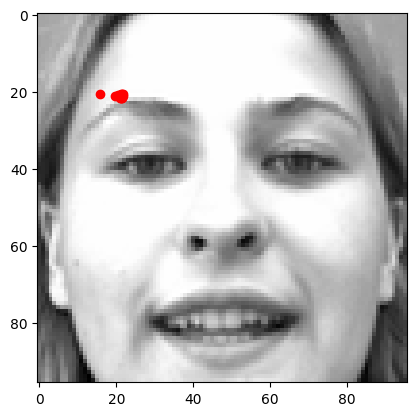

In [10]:
# Plot the first image in the DataFrame
image = np.array(x_test.iloc[1,:])  # Convert the Series to a NumPy array
image = image.reshape((96, 96))  # Reshape the array to the desired image dimensions
predicted_keypoints = predictions[1].reshape((15, 2))
plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='r', marker='o')
plt.imshow(image, cmap='gray')
plt.show()

In [11]:
# Save the model to a file
model.save('/content/simple_model.h5')

In [12]:
# Prepare for output
# Convert the DataFrame to a NumPy array and reshape it
reshaped_values = df_predictions.values.reshape(-1, 1)

# Create a new DataFrame with the reshaped values
reshaped_df = pd.DataFrame(reshaped_values, columns=['Value'])
indices = pd.DataFrame(range(1,len(reshaped_df)+1))
submission = pd.concat([indices, reshaped_df], axis=1)
submission.rename(columns={0: 'RowId','Value': 'Location'}, inplace=True)


In [13]:
# Write to csv file
submission.to_csv('/content/simple_model_submission.csv',index=False)

In [14]:
df['im_submission']

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
result.1,182,183,182,182,180,180,176,169,156,137,...,6,14,28,28,24,18,12,8,5,5
result.2,76,87,81,72,65,59,64,76,69,42,...,156,152,162,169,168,159,191,228,211,168
result.3,177,176,174,170,169,169,168,166,166,166,...,1,1,1,1,1,1,1,1,1,1
result.4,176,174,174,175,174,174,176,176,175,171,...,144,143,141,142,143,142,142,142,142,140
result.5,50,47,44,101,144,149,120,58,48,42,...,254,254,254,253,255,236,174,175,175,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
result.1779,101,101,101,100,100,97,97,98,102,149,...,0,0,0,0,0,0,0,0,0,0
result.1780,201,191,171,158,145,140,136,130,123,115,...,164,184,210,233,221,211,207,205,210,213
result.1781,28,28,29,30,31,32,33,34,39,44,...,79,78,77,77,77,77,77,77,78,78
result.1782,104,95,71,57,46,52,65,70,70,67,...,158,163,160,156,149,150,145,144,151,159
